In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint # Solver Persamaan Diferensial
from scipy.interpolate import interp1d # Untuk interpolasi data time-series

# Konfigurasi visualisasi
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [32]:
FAKTOR_KONVERSI_PADI_BERAS = 0.62  # Asumsi 62% beras dari padi GKG
KG_PER_TON = 1000
KABUPATEN_FILTER = 'KABUPATEN BANDUNG'
TAHUN_START = 2018
TAHUN_END = 2022
STOK_AWAL = 100000.0  # Asumsi Stok Beras Awal pada 1 Januari 2018 (dalam TON)

In [33]:
try:
    # Mengganti nama file sesuai dengan yang telah dibagikan
    df_produksi = pd.read_csv('produksi_padi_berdasarkan_kabupatenkota.csv')
    df_konsumsi = pd.read_csv('tingkat_konsumsi_padi_berdasarkan_kabupatenkota_.csv')
    
    # Memuat data Populasi yang telah kita buat sebelumnya
    data_populasi = {
        'tahun': [2018, 2019, 2020, 2021, 2022],
        'populasi': [3598349, 3639268, 3623778, 3674528, 3714948]
    }
    df_populasi = pd.DataFrame(data_populasi)
    
except FileNotFoundError as e:
    print(f"ERROR: File data tidak ditemukan. Pastikan Anda mengunggah semua file CSV: {e}")
    # Hentikan eksekusi jika file tidak ada
    raise

# Filtering dan Pembersihan
print(f"--- Memproses Data {KABUPATEN_FILTER} (Tahun {TAHUN_START}-{TAHUN_END}) ---")

# Data Produksi Padi (TON)
df_prod = df_produksi[
    (df_produksi['nama_kabupaten_kota'] == KABUPATEN_FILTER) &
    (df_produksi['tahun'] >= TAHUN_START) &
    (df_produksi['tahun'] <= TAHUN_END)
][['tahun', 'produksi_padi']]

# Data Tingkat Konsumsi (KG/KAP/TAHUN)
df_kons = df_konsumsi[
    (df_konsumsi['nama_kabupaten_kota'] == KABUPATEN_FILTER) &
    (df_konsumsi['tahun'] >= TAHUN_START) &
    (df_konsumsi['tahun'] <= TAHUN_END)
].rename(columns={'total': 'konsumsi_per_kapita'})[['tahun', 'konsumsi_per_kapita']]

# Data Populasi (Jiwa) - sudah difilter berdasarkan data yang kita buat

# Menggabungkan DataFrame
df_merged = df_prod.merge(df_kons, on='tahun', how='inner')
df_merged = df_merged.merge(df_populasi, on='tahun', how='inner')
df_merged.set_index('tahun', inplace=True)

print("\n--- DATA HISTORIS YANG DIGABUNGKAN (2018-2022) ---")
print(df_merged)

--- Memproses Data KABUPATEN BANDUNG (Tahun 2018-2022) ---

--- DATA HISTORIS YANG DIGABUNGKAN (2018-2022) ---
       produksi_padi  konsumsi_per_kapita  populasi
tahun                                              
2018        609329.0                114.1   3598349
2019        785685.0                112.1   3639268
2020        550372.0                107.5   3623778
2021        310715.2                110.4   3674528
2022        289205.7                102.3   3714948


In [34]:
years = df_merged.index.values.astype(float)

# Fungsi Produksi Padi
produksi_interp = interp1d(years, df_merged['produksi_padi'].values, 
                           kind='linear', fill_value='extrapolate')
# Fungsi Konsumsi per Kapita
konsumsi_interp = interp1d(years, df_merged['konsumsi_per_kapita'].values, 
                           kind='linear', fill_value='extrapolate')
# Fungsi Populasi
populasi_interp = interp1d(years, df_merged['populasi'].values, 
                           kind='linear', fill_value='extrapolate')

interp_funcs = {
    'produksi': produksi_interp,
    'konsumsi': konsumsi_interp,
    'populasi': populasi_interp
}

In [35]:
def model_ketersediaan_beras(stok_beras, t, interp_funcs):
    
    # 1. Panggil fungsi interpolasi untuk mendapatkan nilai input pada waktu t
    prod_padi = interp_funcs['produksi'](t).item()
    kons_kapita = interp_funcs['konsumsi'](t).item()
    pop_total = interp_funcs['populasi'](t).item()
    
    # 2. INFLOW: Laju Produksi Beras (Ton/Tahun)
    # Padi (Ton) * Faktor Konversi Padi ke Beras
    laju_produksi = prod_padi * FAKTOR_KONVERSI_PADI_BERAS
    
    # 3. OUTFLOW: Laju Konsumsi Beras (Ton/Tahun)
    # (Konsumsi per Kapita (Kg) * Populasi (Jiwa)) / 1000 (Kg/Ton)
    laju_konsumsi = (kons_kapita * pop_total) / KG_PER_TON
    
    # 4. Net Flow (Persamaan Diferensial)
    dStok_dt = laju_produksi - laju_konsumsi
    
    # Catatan: odeint hanya memerlukan dStok_dt untuk simulasi
    return dStok_dt

In [36]:
# --- 7. SIMPAN HASIL KE FILE JSON UNTUK WEB ---
import json

# Siapkan data untuk frontend
data_for_web = {
    "tahun": t_span.tolist(),
    "stok_beras": stok_beras_simulasi.tolist(),
    "laju_produksi": laju_prod_sim,
    "laju_konsumsi": laju_kons_sim
}

# Simpan ke file static agar bisa diakses oleh web
output_path = 'static/data_simulasi_beras.json'
os.makedirs('static', exist_ok=True)  # Buat folder static jika belum ada

with open(output_path, 'w') as f:
    json.dump(data_for_web, f, indent=2)

print(f"\n✅ Data simulasi disimpan ke: {output_path}")


✅ Data simulasi disimpan ke: static/data_simulasi_beras.json



--- HASIL SIMULASI (5 Baris Awal) ---
         Tahun     Stok_Beras  Laju_Produksi  Laju_Konsumsi      Net_Flow
0  2018.000000  100000.000000  377783.980000  410571.620900 -32787.640900
1  2018.081633   97696.214687  386709.753061  410364.721247 -23654.968185
2  2018.163265   96137.996127  395635.526122  410156.730875 -14521.204752
3  2018.244898   95325.435427  404561.299184  409947.649783  -5386.350600
4  2018.326531   95258.621627  413487.072245  409737.477974   3749.594271


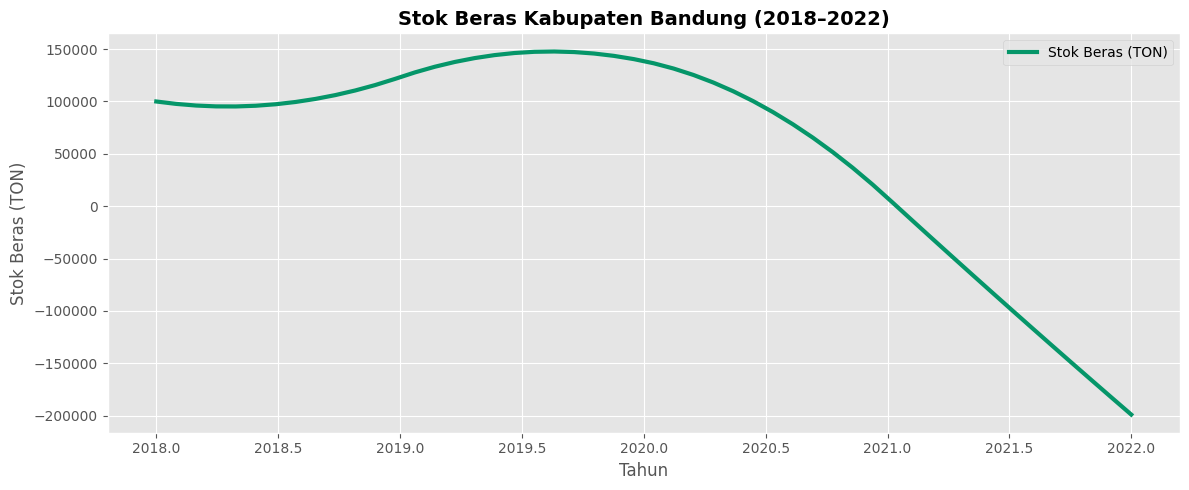

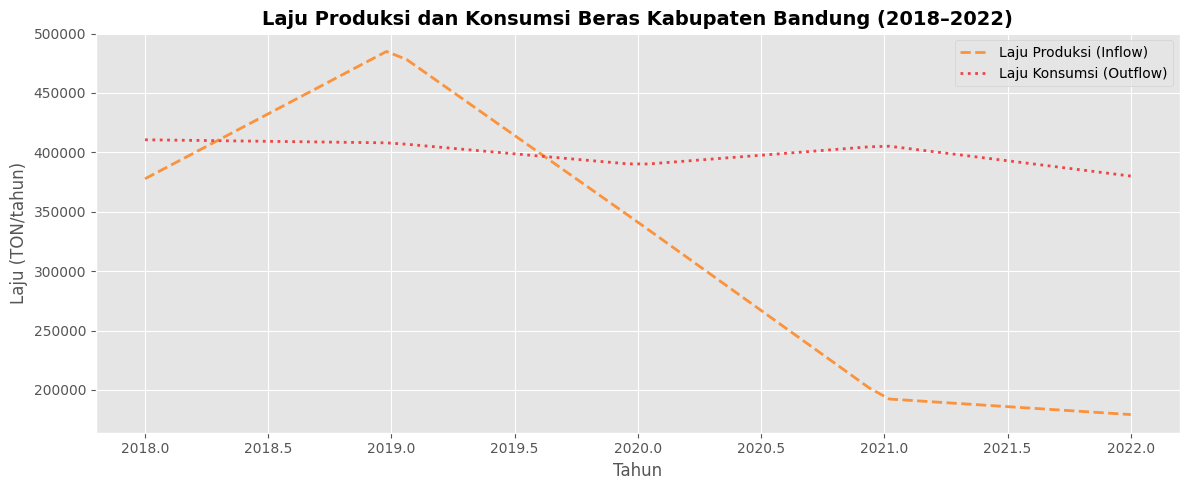

In [37]:
# --- 7. EKSTRAKSI DAN VISUALISASI HASIL (DIPISAH MENJADI 2 GRAFIK) ---

# Ekstraksi Laju Produksi dan Konsumsi (untuk plot dan analisis)
laju_prod_sim = [interp_funcs['produksi'](t).item() * FAKTOR_KONVERSI_PADI_BERAS for t in t_span]
laju_kons_sim = [(interp_funcs['konsumsi'](t).item() * interp_funcs['populasi'](t).item()) / KG_PER_TON for t in t_span]

# Buat DataFrame Hasil Simulasi
df_results = pd.DataFrame({
    'Tahun': t_span,
    'Stok_Beras': stok_beras_simulasi,
    'Laju_Produksi': laju_prod_sim,
    'Laju_Konsumsi': laju_kons_sim,
    'Net_Flow': np.array(laju_prod_sim) - np.array(laju_kons_sim)
})

# Tampilkan 5 baris pertama hasil simulasi
print("\n--- HASIL SIMULASI (5 Baris Awal) ---")
print(df_results.head())

# === Plot 1: Stok Beras ===
plt.figure(figsize=(12, 5))
plt.plot(df_results['Tahun'], df_results['Stok_Beras'], 
         label='Stok Beras (TON)', color='#059669', linewidth=3)
plt.title('Stok Beras Kabupaten Bandung (2018–2022)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Stok Beras (TON)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot 2: Laju Produksi vs Konsumsi ===
plt.figure(figsize=(12, 5))
plt.plot(df_results['Tahun'], df_results['Laju_Produksi'], 
         label='Laju Produksi (Inflow)', color='#fb923c', linestyle='--', linewidth=2)
plt.plot(df_results['Tahun'], df_results['Laju_Konsumsi'], 
         label='Laju Konsumsi (Outflow)', color='#ef4444', linestyle=':', linewidth=2)
plt.title('Laju Produksi dan Konsumsi Beras Kabupaten Bandung (2018–2022)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Laju (TON/tahun)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
print("\n--- RINGKASAN ANALISIS SIMULASI ---")
stok_akhir = df_results['Stok_Beras'].iloc[-1]
stok_perubahan = stok_akhir - STOK_AWAL

print(f"Stok Awal (2018): {STOK_AWAL:,.0f} TON")
print(f"Stok Akhir (2022): {stok_akhir:,.0f} TON")

if stok_perubahan < 0:
    print(f"\nHASIL: Terjadi DEFIZIT/PENURUNAN stok sebesar {abs(stok_perubahan):,.0f} TON dalam 5 tahun.")
    print("Interpretasi: Laju Konsumsi rata-rata lebih tinggi dari Laju Produksi.")
else:
    print(f"\nHASIL: Terjadi SURPLUS/PENINGKATAN stok sebesar {stok_perubahan:,.0f} TON dalam 5 tahun.")
    print("Interpretasi: Laju Produksi rata-rata lebih tinggi dari Laju Konsumsi.")

print("\nData ini menunjukkan kebutuhan mendesak akan intervensi kebijakan untuk menyeimbangkan Inflow dan Outflow.")


--- RINGKASAN ANALISIS SIMULASI ---
Stok Awal (2018): 100,000 TON
Stok Akhir (2022): -198,979 TON

HASIL: Terjadi DEFIZIT/PENURUNAN stok sebesar 298,979 TON dalam 5 tahun.
Interpretasi: Laju Konsumsi rata-rata lebih tinggi dari Laju Produksi.

Data ini menunjukkan kebutuhan mendesak akan intervensi kebijakan untuk menyeimbangkan Inflow dan Outflow.
